# Circulation
This plots the stream function when monsoon is occuring in summer, and just prior to this at the equinox.

In [553]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
# Use custom matplotlib style for publishing
plt.style.use(os.environ['PWD']+'/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
import matplotlib
import matplotlib.animation
from scipy import optimize
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
matplotlib.rcParams['lines.linewidth'] = 0.8          # make lines bigger for presentation

In [64]:
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat, clausius_clapeyron_factor
from isca_tools.convection import lcl_temp
from isca_tools.convection.base import convection_neutral_profile, dry_profile_pressure
from isca_tools.utils.constants import g, R, radius_earth, c_p, L_v
from isca_tools.utils import area_weighting, annual_time_slice
from isca_tools.utils.ds_slicing import annual_mean
from isca_tools.thesis.adiabat_theory import get_z_ft_approx, get_temp_adiabat_surf, get_temp_adiabat
from isca_tools.utils.circulation import get_stream
from isca_tools.utils.calculus import grad_y

In [283]:
exp_dir = 'tau_sweep/aquaplanet/depth=1/'
exp_names = {'conv': [f"k=1", f"tau_grad/tau0=7_5"], 
             'no_conv': [f"no_conv/k=1", f"no_conv/tau0=7_5"]}
use_time_start = 360*2

ds = {key: [] for key in exp_names}
albedo = []
tau_sw = []
tau_lw = []
n_exp = len(exp_names['conv'])

var_keep = ['temp', 'sphum', 'height', 't_surf', 'precipitation', 'flux_lhe', 'lwdn_sfc', 'lwup_sfc', 'ucomp', 'vcomp']      # only keep winds

# Use all data after 2 years, as clearly converged from the above spin up plot
# lat_use = slice(-65, 90)        # only interested where Hadley circulation occurs
# # summer_months = [6, 7, 8]
# summer_months = [7, 8]
# # summer_months = [8, 9]
# just_summer = True
with tqdm(total=n_exp*len(exp_names), position=0, leave=True) as pbar:
    for key in ds:
        for i in range(n_exp):
            ds_use = isca_tools.load_dataset(exp_dir + exp_names[key][i])
            try:
                ds_use = ds_use[var_keep]
            except KeyError:
                remove_keys = []
                for key in var_keep:
                    if key not in ds_use:
                        print(f'Removing {key} from var_keep')
                        remove_keys += [key]
                for key in remove_keys:
                    var_keep.remove(key)
                ds_use = ds_use[var_keep]
            # Take zonal mean
            ds_use = annual_mean(ds_use.sel(time=slice(use_time_start, np.inf)).mean(dim=['lon']))
            ds[key] += [ds_use.load()]   
            # if just_summer:
            #     ds[key] += [annual_time_slice(ds_use, include_months=summer_months).load()]
            # else:
            #     ds[key] += [ds_use.load()]   
            if key == 'conv':
                namelist = isca_tools.load_namelist(exp_dir + exp_names[key][i])  # Need this for albedo_value
                albedo += [namelist['mixed_layer_nml']['albedo_value']]
                tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
                tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
            pbar.update(1)

 25%|██▌       | 1/4 [00:27<01:22, 27.36s/it]/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:52: UserWarning: First month saved is 25 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
 50%|█████     | 2/4 [00:52<00:52, 26.06s/it]/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:52: UserWarning: First month saved is 25 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
 75%|███████▌  | 3/4 [01:17<00:25, 25.65s/it]/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:52: UserWarning: First month saved is 25 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
100%|██████████| 4/4 [01:42<00:00, 25.74s/it]


In [284]:
# If true, will save all figures to desktop - option to save specific figures later on.
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [285]:
ind_eq = int(np.abs(ds['conv'][0].lat).argmin())
ind_surf = int(np.abs(ds['conv'][0].pfull).argmax())
p_ft_approx = 500
ind_ft = int(np.abs(ds['conv'][0].pfull - p_ft_approx).argmin())
p_ft = float(ds['conv'][0].pfull[ind_ft])*100
p_surface = float(ds['conv'][0].pfull[ind_surf])*100
n_pressure = ds['conv'][0].pfull.size
n_lat = ds['conv'][0].lat.size
lat = ds['conv'][0].lat

## Subtropical Temperature Amplification
For our aquaplanet simulations, we see temperature is peaked off the equator. The amplitude of this peak increases with warming, both at the surface (solid) and free troposphere (dotted).

It seems we should explain this before introducing land.

In [286]:
summer_months = [7, 8]

mse_surf = {key: np.zeros((n_exp, n_lat)) for key in ds}
mse_ft = {key: np.zeros((n_exp, n_lat)) for key in ds}       # in units of K
z_ft = {key: np.zeros((n_exp, n_lat)) for key in ds}
temp_ft = {key: np.zeros((n_exp, n_lat)) for key in ds}
temp_surf = {key: np.zeros((n_exp, n_lat)) for key in ds}
rh = {key: np.zeros((n_exp, n_lat)) for key in ds}
for key in ds:
    for i in range(n_exp):
        if 'height' in ds[key][0]:
            ds_use = ds[key][i].isel(pfull=[ind_surf, ind_ft])[['temp', 'sphum', 'height']]
        else:
            ds_use = ds[key][i].isel(pfull=[ind_surf, ind_ft])[['temp', 'sphum']]
            height = get_z_ft_approx(ds_use.temp[:, 1], ds_use.temp[:, 0], p_surface, p_ft)
            height = height.expand_dims(dim={"pfull": 2}) * np.asarray([0, 1]).reshape(2, 1, 1)     # set surface height to 0
            height = height.transpose('time', 'pfull', 'lat')
            ds_use['height'] = height
        ds_use = annual_time_slice(ds_use, include_months=summer_months)
        ds_use['mse_surf'] = moist_static_energy(ds_use.temp[:, 0], ds_use.sphum[:, 0], ds_use.height[:, 0])
        ds_use['mse_ft'] = moist_static_energy(ds_use.temp[:, 1], sphum_sat(ds_use.temp[:, 1], p_ft), ds_use.height[:, 1])
        ds_use['rh'] = ds_use.sphum[:, 0] / sphum_sat(ds_use.temp[:, 0], p_surface)
        ds_use = ds_use.mean(dim='time')
        mse_surf[key][i] = ds_use.mse_surf*1000/c_p      # in units of K
        mse_ft[key][i] = ds_use.mse_ft*1000/c_p
        z_ft[key][i] = ds_use.height[1]
        temp_ft[key][i] = ds_use.temp[1]
        temp_surf[key][i] = ds_use.temp[0]
        rh[key][i] = ds_use.rh

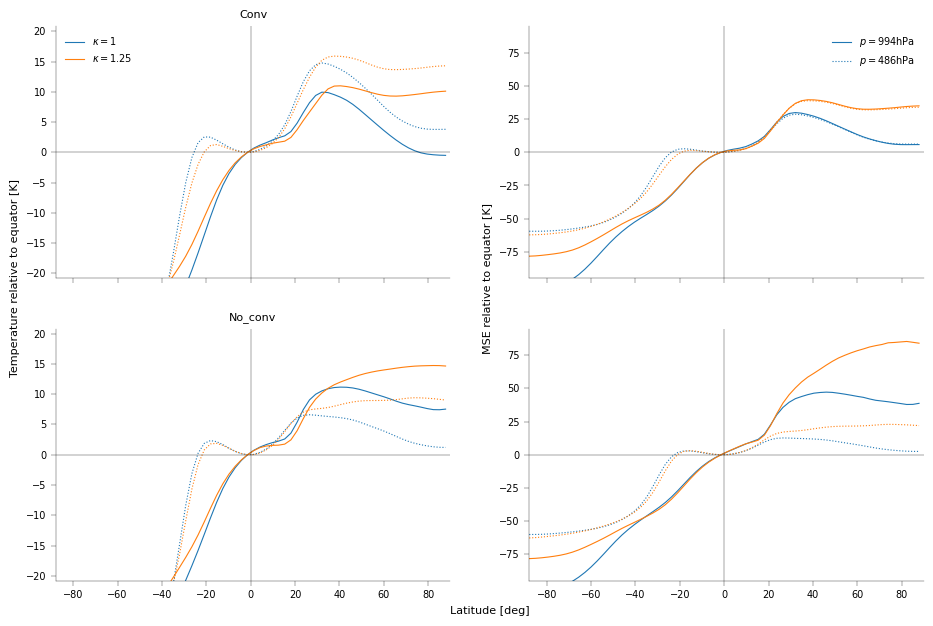

In [287]:
fig, ax = plt.subplots(2,2, figsize=(3.5*width['one_col'], 3*width['one_col']/ar), sharex=True, sharey='col')
for j, key in enumerate(ds):
    ax[j, 0].set_title(key.capitalize())
    for i in range(n_exp):
        ax[j, 0].plot(lat, temp_surf[key][i]-temp_surf[key][i, ind_eq], color=default_colors[i], label=f'$\kappa = {tau_lw[i]}$')
        ax[j, 0].plot(lat, temp_ft[key][i]-temp_ft[key][i, ind_eq], color=default_colors[i], linestyle=':')
        ax[j, 1].plot(lat, mse_surf[key][i]-mse_surf[key][i, ind_eq], color=default_colors[i], 
                      label=f'$p = {int(p_surface/100)}$hPa' if i==0 else None)
        ax[j, 1].plot(lat, mse_ft[key][i]-mse_ft[key][i, ind_eq], color=default_colors[i], linestyle=':', 
                      label=f'$p = {int(p_ft/100)}$hPa' if i==0 else None)
ax[0, 0].set_xlim(lat.min(), 90)
ax[0, 0].set_ylim(-ax[0, 0].get_ylim()[1], ax[0, 0].get_ylim()[1])
ax[0, 1].set_ylim(-ax[0, 1].get_ylim()[1], ax[0, 1].get_ylim()[1])
for ax_use in ax.flatten():
    ax_use.axhline(0, color='k', lw=ax_linewidth)
    ax_use.axvline(0, color='k', lw=ax_linewidth)
ax[0, 0].legend()
ax[0, 1].legend()
ax[0, 0].set_ylabel('Temperature relative to equator [K]', y=0)
ax[0, 1].set_ylabel('MSE relative to equator [K]', y=0)
ax[1, 1].set_xlabel('Latitude [deg]', x=-0.1);

In [288]:
temp_surf_adiabat = {key: np.zeros((n_exp, n_lat)) for key in ds}
for key in ds:
    for i in range(n_exp):
        for j in range(n_lat):
            temp_surf_adiabat[key][i, j] = get_temp_adiabat_surf(rh[key][i, j], temp_ft[key][i, j], z_ft[key][i, j], p_surface, p_ft)[0]

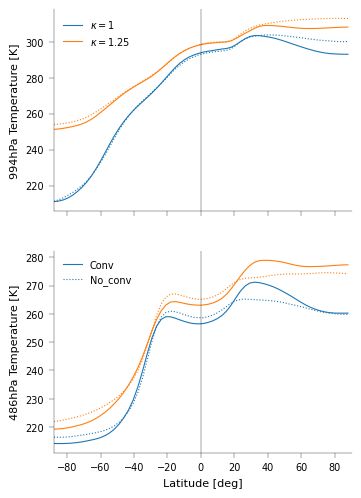

In [289]:
linestyles_conv = {'conv': '-', 'no_conv': ':'}
fig, ax = plt.subplots(2,1, figsize=(1.2*width['one_col'], 2*1.2*width['one_col']/ar), sharex=True)
for key in ds:
    for i in range(n_exp):
        ax[0].plot(lat, temp_surf[key][i], color=default_colors[i], linestyle=linestyles_conv[key], 
                   label=f'$\kappa = {tau_lw[i]}$' if key=='conv' else None)
        # ax[0].plot(lat, temp_surf_adiabat[key][i], color=default_colors[3], linestyle=linestyles_conv[key], lw=ax_linewidth)
        ax[1].plot(lat, temp_ft[key][i], color=default_colors[i], linestyle=linestyles_conv[key], 
                   label=key.capitalize() if i==0 else None)
for ax_use in ax:
    ax_use.legend()
    ax_use.axvline(0, color='k', lw=ax_linewidth)
ax[0].set_xlim(lat.min(), 90)
ax[1].set_xlabel('Latitude [deg]')
ax[0].set_ylabel(f'{int(p_surface/100)}hPa Temperature [K]')
ax[1].set_ylabel(f'{int(p_ft/100)}hPa Temperature [K]')
fig.savefig(f"/Users/joshduffield/Desktop/conv_temp.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Conv vs Non-Conv Temperature Profile
Below, there is a gif showing evolution of temperature profile at given latitude (Convective vs Non-Convective). It seems to show surface evolves and then atmosphere follows. 

In [756]:
month_names = ['January','February','March','April','May','June','July','August','September','October','November','December']
n_time = ds['conv'][0].time.size
profile_lat_ind = int(np.abs(ds['conv'][0].lat - 60).argmin())
profile_lat = float(ds['conv'][0].lat[profile_lat_ind])
profile_exp_ind = 1
profile_pressure_use = slice(350, np.inf)
ds_use = {key: ds[key][profile_exp_ind].isel(lat=profile_lat_ind).sel(pfull=profile_pressure_use) for key in ds}
gif_info = {'temp': {key: ds_use[key].temp.to_numpy() for key in ds_use},
            't_surf': {key: ds_use[key].t_surf.to_numpy() for key in ds_use},
            'pfull': ds_use['conv'].pfull,
            'lcl': {'temp': np.asarray([lcl_temp(ds_use['conv'].temp.isel(pfull=-1)[i], p_surface, 
                                                 ds_use['conv'].sphum.isel(pfull=-1)[i]) for i in range(n_time)])}}

gif_info['lcl']['pressure'] = dry_profile_pressure(ds_use['conv'].temp.isel(pfull=-1), p_surface, gif_info['lcl']['temp'])
gif_info['temp_adiabat'] = np.asarray([convection_neutral_profile(float(ds_use['conv'].temp.isel(pfull=-1)[i]), p_surface, 
                                                                  gif_info['lcl']['temp'][i], ds_use['conv'].pfull.to_numpy()*100) for i in range(n_time)])
gif_info['ax_lims'] = {'temp': [np.min([gif_info['temp'][key].min() for key in ds_use]), 
                                np.max([gif_info['t_surf'][key].max() for key in ds_use])], 
                       'temp_diff': [np.min([(gif_info[key]['conv'] - gif_info[key]['no_conv']).min() 
                                             for key in ['temp', 't_surf']]), 
                                     np.max([(gif_info[key]['conv'] - gif_info[key]['no_conv']).max() 
                                             for key in ['temp', 't_surf']])]
                       }
# fig, ax = plt.subplots(1, 2, figsize=(8, 6), width_ratios=[3, 1], sharey=True)
# for key in ds_use:
#     ax[0].plot(ds_use[key].temp.isel(time=0), ds_use[key].pfull, color='k', linestyle=linestyles_conv[key])
# ax[1].plot((ds_use['conv'].temp - ds_use['no_conv'].temp).isel(time=0), ds_use[key].pfull, color='k')
# ax[1].axvline(0, color='k', lw=ax_linewidth)

In [757]:
def animate(n, fig, var_info):
    ax = fig.axes
    ax[0].clear() 
    ax[1].clear()
    for key in var_info['temp']:
        ax[0].plot(var_info['temp'][key][n], var_info['pfull'], color='k', linestyle=linestyles_conv[key], label=key.capitalize())
        ax[0].scatter(var_info['t_surf'][key][n], var_info['pfull'][-1], marker='|', color='k', s=400, linestyle=linestyles_conv[key], lw=1)
    ax[0].plot(var_info['temp_adiabat'][n], var_info['pfull'], color=default_colors[3], lw=ax_linewidth, label='Moist Adiabat')
    
    ax[1].plot(var_info['temp']['conv'][n] - var_info['temp']['no_conv'][n], gif_info['pfull'], color='k')
    ax[1].plot(var_info['temp']['conv'][n] - var_info['temp_adiabat'][n], gif_info['pfull'], color=default_colors[3], lw=ax_linewidth)
    ax[1].scatter(var_info['t_surf']['conv'][n] - var_info['t_surf']['no_conv'][n], var_info['pfull'][-1], marker='|', color='k', s=400, lw=1)
    
    ax[1].axvline(0, color='k', lw=ax_linewidth)
    ax[0].invert_yaxis()
    ax[0].set_ylim(var_info['pfull'].max(), var_info['pfull'].min())
    ax[0].set_xlim(var_info['ax_lims']['temp'])
    ax[1].set_xlim(var_info['ax_lims']['temp_diff'])
    ax[0].legend(loc='upper right')
    
    # Axis labels
    ax[0].set_ylabel('Pressure [hPa]')
    ax[0].set_xlabel('Temperature [K]')
    ax[1].set_xlabel('Temperature Diff [K]')
    fig.suptitle(f'{month_names[int(np.floor(n/30))]} {n%30+1}', fontsize=7, y=0.9)

# fig, ax = plt.subplots(1, 2, figsize=(8, 4), width_ratios=[3, 1], sharey=True)
# anim = FuncAnimation(fig, animate, frames=n_time, interval=100,
#                      blit=False, repeat_delay=200, fargs=(fig, gif_info))
# HTML(anim.to_jshtml())

In [758]:
# Save animation
# writervideo = matplotlib.animation.PillowWriter(fps=6) 
# anim.save(f'/Users/joshduffield/Desktop/temp_profile_conv_no_conv_lat{int(profile_lat)}.gif' , writer=writervideo)

### Annual Mean Surface Temperature
The evolution of surface temperature is pretty similar with vs without convection. The differences can be explained by the latent heat term in the surface flux.

Lower latent heat means higher temperature tendency, and thus higher temperature reached.

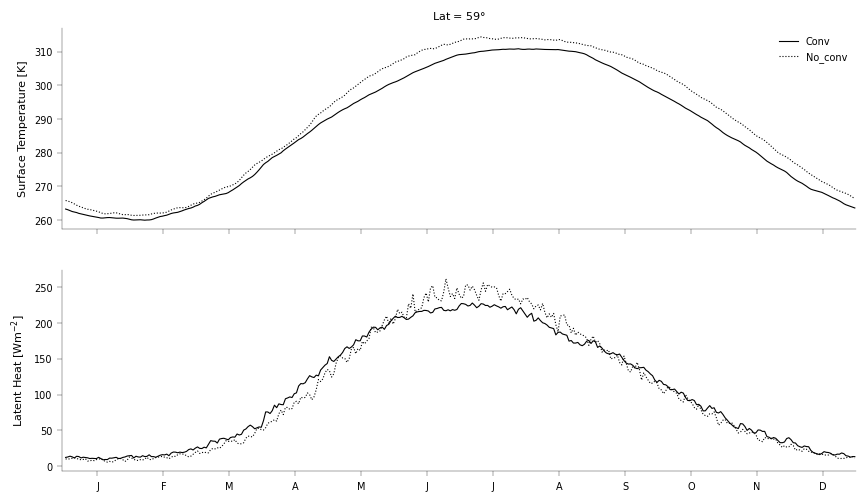

In [759]:
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])

fig, ax = plt.subplots(2,1, figsize=(3.2*width['one_col'], 2*1.2*width['one_col']/ar), sharex=True)
for key in ds_use:
    ax[0].plot(ds_use[key].time, ds_use[key].t_surf, color='k', linestyle=linestyles_conv[key], label=key.capitalize())
    # ax[0].plot(ds_use[key].time, ds_use[key].temp[:, -1], color='k', linestyle=linestyles_conv[key], label=key.capitalize(), alpha=0.3)
    ax[1].plot(ds_use[key].time, ds_use[key].flux_lhe, color='k', linestyle=linestyles_conv[key])
ax[0].set_xticks(*month_ticks)
ax[0].legend()
ax[0].set_xlim(-1, 360)
ax[0].set_ylabel('Surface Temperature [K]')
ax[1].set_ylabel('Latent Heat [Wm$^{-2}$]')
ax[0].set_title(f'Lat = {int(profile_lat)}$\degree$');

### Phase Shift between Surface and 500hPa
Below I use non-convective days to fit $T_{FT} = \lambda_0 + \lambda_1 T_s(t - \Delta)$ i.e. free troposphere evolves according to surface but with a phase delay of $\Delta$ days and a different amplitude. Dashed line.

Equally, I use convective days to fit $h^*_{FT} = \lambda_0 + \lambda_1 h_s(t - \Delta)$ i.e. free troposphere saturated MSE evolves according to surface but with a phase delay of $\Delta$ days, and different amplitude. Not sure about allowing a different amplitude. Dotted line.

Clearly we need a combination of the fits for when the convective scheme is off. The phasing of the dashed line is pretty similar for convective vs non-convective days though, indicating same processes set this phase.

In [760]:
mse_surf_timeseries = {key: moist_static_energy(ds_use[key].temp[:, -1], ds_use[key].sphum[:, -1], ds_use[key].height[:, -1]) for key in ds_use}
ind_ft_use = int(np.abs(ds_use['conv'].pfull - p_ft_approx).argmin())
mse_ft_timeseries = {key: moist_static_energy(ds_use[key].temp[:, ind_ft_use], 
                                              sphum_sat(ds_use[key].temp[:, ind_ft_use], ds_use[key].pfull[ind_ft_use]*100), 
                                              ds_use[key].height[:, ind_ft_use]) for key in ds_use}

In [776]:
def linear_func_shift(time, a, b, c, spline):
    x_var_shift = spline(time-c)
    return a + b*x_var_shift

conv_thresh = -8        # Use days where h_s - h_{FT}^* > conv_thresh to fit convective temperature profile at 500hPa
conv_ind = {'conv': mse_surf_timeseries['conv'] - mse_ft_timeseries['conv'] > conv_thresh, 
            'no_conv': mse_surf_timeseries['no_conv']<0}        # for no conv, all are zero
t_anom_spline_fit = {}
t_ft_fit_params = {}
t_ft_fit = {}
mse_ft_fit = {}
for key in conv_ind:
    t_anom_spline_fit[key] = scipy.interpolate.CubicSpline(np.append(ds_use[key].time.to_numpy(), ds_use[key].time[-1]+1), 
                                                           np.append(ds_use[key].temp[:, -1] - ds_use[key].temp[:, -1].mean(),
                                                                     (ds_use[key].temp[:, -1] - ds_use[key].temp[:, -1].mean())[0]),
                                                            bc_type='periodic')
    # Use non-convective days to fit FT temperature, as this lags surface for non-convective days
    t_ft_fit_params[key] = optimize.curve_fit(lambda x, a, b, c: linear_func_shift(x, a, b, c, t_anom_spline_fit[key]), 
                                                   ds_use[key].time.to_numpy()[~conv_ind['no_conv']], 
                                                   (ds_use[key].temp[:, ind_ft_use] - 
                                                    ds_use[key].temp[:, ind_ft_use].mean())[~conv_ind['no_conv']])[0]
    t_ft_fit[key] = linear_func_shift(ds_use[key].time, *t_ft_fit_params[key], t_anom_spline_fit[key]) + \
                                float(ds_use[key].temp[:, ind_ft_use].mean())
    
    mse_ft_fit[key] = moist_static_energy(t_ft_fit[key], sphum_sat(t_ft_fit[key], p_ft), 
                                     ds_use[key].height[:, ind_ft_use])

plot_key = 'conv'
mse_surf_spline_fit = scipy.interpolate.CubicSpline(np.append(ds_use[plot_key].time.to_numpy(), ds_use[plot_key].time[-1]+1), 
                                                       np.append(mse_surf_timeseries[plot_key], mse_surf_timeseries[plot_key][0]),
                                                  bc_type='periodic')
mse_ft_fit_params = optimize.curve_fit(lambda x, a, b, c: linear_func_shift(x, a, b, c, mse_surf_spline_fit), 
                                       ds_use[plot_key].time.to_numpy()[conv_ind[plot_key]], mse_ft_timeseries[plot_key][conv_ind[plot_key]])[0]
mse_ft_fit_params = [mse_ft_fit_params[0], mse_ft_fit_params[1], mse_ft_fit_params[-1]]
mse_ft_fit['conv_conv'] = linear_func_shift(ds_use[plot_key].time, *mse_ft_fit_params, mse_surf_spline_fit)
t_ft_fit['conv_conv'] = np.asarray([optimize.fsolve(lambda x: moist_static_energy(x, sphum_sat(x, p_ft), 
                                                                          float(ds_use['conv'].height[:, ind_ft_use][i])) - 
                                                      float(mse_ft_fit['conv_conv'][i]), 270) for i in range(n_time)])

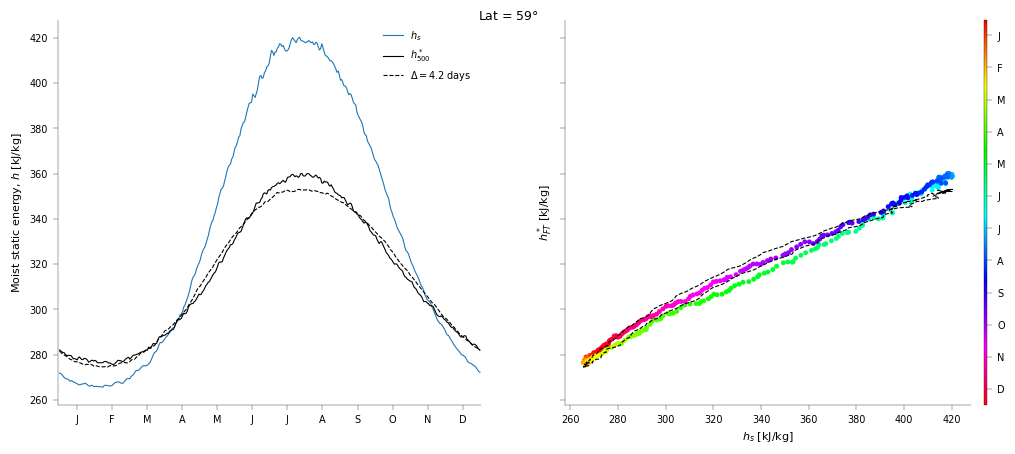

In [777]:
fig, ax = plt.subplots(1,2, figsize=(12, 5), sharey=True)
plot_key = 'no_conv'
ax[0].plot(ds_use[plot_key].time, mse_surf_timeseries[plot_key], color=default_colors[0], label='$h_s$')
ax[0].plot(ds_use[plot_key].time, mse_ft_timeseries[plot_key], color='k', label=f"$h_{'{'+str(p_ft_approx)+'}'}^*$")
im = ax[1].scatter(mse_surf_timeseries[plot_key], mse_ft_timeseries[plot_key], c=ds_use['conv'].time, cmap='hsv')
ax[0].plot(ds_use[plot_key].time, mse_ft_fit[plot_key], color='k', linestyle='--', 
           label=f"{'Non-conv Fit: ' if plot_key=='conv' else ''}$\Delta = {round(t_ft_fit_params[plot_key][-1], 1)}$ days")
ax[1].plot(mse_surf_timeseries[plot_key], mse_ft_fit[plot_key], color='k', linestyle='--')
if plot_key == 'conv':
    ax[0].plot(ds_use[plot_key].time, mse_ft_fit['conv_conv'], color='k', linestyle=':', 
               label=f"Conv Fit: $\Delta = {round(mse_ft_fit_params[-1], 1)}$ days")
    ax[1].plot(mse_surf_timeseries[plot_key], mse_ft_fit['conv_conv'], color='k', linestyle=':')

cbar = fig.colorbar(im, ax=ax[1], aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
# ax[1].set_ylim(310, 340)
# ax[1].set_xlim(310, 340)

ax[0].set_ylabel('Moist static energy, $h$ [kJ/kg]')
ax[1].set_xlabel('$h_s$ [kJ/kg]')
ax[1].set_ylabel('$h^*_{FT}$ [kJ/kg]')
ax[0].set_xticks(*month_ticks)
ax[0].set_xlim(-1, 360)
ax[0].legend()
fig.suptitle(f'Lat = {int(profile_lat)}$\degree$', fontsize=9, y=0.9);

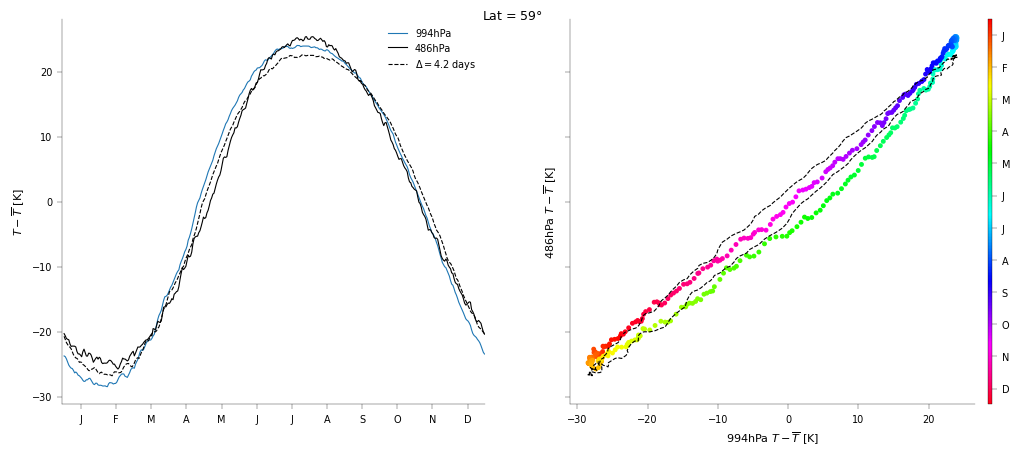

In [778]:
fig, ax = plt.subplots(1,2, figsize=(12, 5), sharey=True)
plot_key = 'no_conv'
ax[0].plot(ds_use[plot_key].time, ds_use[plot_key].temp[:, -1] - ds_use[plot_key].temp[:, -1].mean(), color=default_colors[0], 
           label=str(int(ds_use['conv'].pfull[-1]))+'hPa')
ax[0].plot(ds_use[plot_key].time, ds_use[plot_key].temp[:, ind_ft_use] - ds_use[plot_key].temp[:, ind_ft_use].mean(), 
           color='k', label=str(int(ds_use['conv'].pfull[ind_ft_use]))+'hPa')
im = ax[1].scatter(ds_use[plot_key].temp[:, -1] - ds_use[plot_key].temp[:, -1].mean(), 
                   ds_use[plot_key].temp[:, ind_ft_use] - ds_use[plot_key].temp[:, ind_ft_use].mean(), c=ds_use['conv'].time, cmap='hsv')
ax[0].plot(ds_use[plot_key].time, t_ft_fit[plot_key] - float(ds_use[plot_key].temp[:, ind_ft_use].mean()), color='k', linestyle='--', 
           label=f"{'Non-conv Fit: ' if plot_key=='conv' else ''}$\Delta = {round(t_ft_fit_params[plot_key][-1], 1)}$ days")
ax[1].plot(ds_use[plot_key].temp[:, -1] - ds_use[plot_key].temp[:, -1].mean(), t_ft_fit[plot_key] - 
           float(ds_use[plot_key].temp[:, ind_ft_use].mean()), color='k', linestyle='--')

if plot_key == 'conv':
    ax[0].plot(ds_use[plot_key].time, t_ft_fit['conv_conv'] - float(ds_use[plot_key].temp[:, ind_ft_use].mean()), color='k', linestyle=':', 
               label=f"Conv Fit: $\Delta = {round(mse_ft_fit_params[-1], 1)}$ days")
    ax[1].plot(ds_use[plot_key].temp[:, -1] - ds_use[plot_key].temp[:, -1].mean(), t_ft_fit['conv_conv'] - 
               float(ds_use[plot_key].temp[:, ind_ft_use].mean()), color='k', linestyle=':')

cbar = fig.colorbar(im, ax=ax[1], aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)

ax[0].set_xticks(*month_ticks)
ax[0].set_xlim(-1, 360)
ax[0].set_ylabel('$T - \overline{T}$ [K]')
ax[1].set_xlabel(f"{int(ds_use['conv'].pfull[-1])}hPa"+" $T - \overline{T}$ [K]")
ax[1].set_ylabel(f"{int(ds_use['conv'].pfull[ind_ft_use])}hPa"+" $T - \overline{T}$ [K]")
ax[0].legend()
fig.suptitle(f'Lat = {int(profile_lat)}$\degree$', fontsize=9, y=0.9);

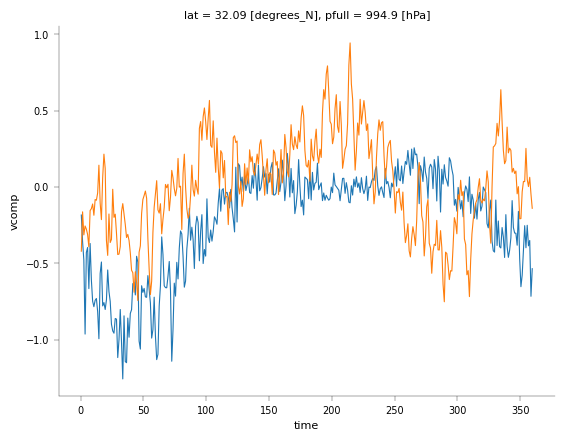

In [534]:
ds_use[plot_key].vcomp[:, 1].plot()
ds_use[plot_key].vcomp[:, -1].plot()
# ds_use['no_conv'].temp[:, -1].plot()

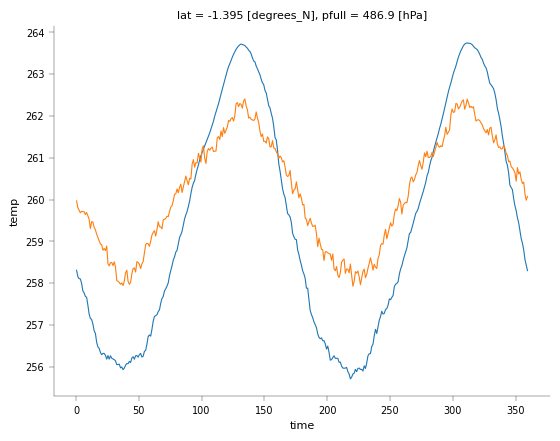

In [402]:
ds_use['conv'].temp[:, 1].plot()
ds_use['no_conv'].temp[:, 1].plot()

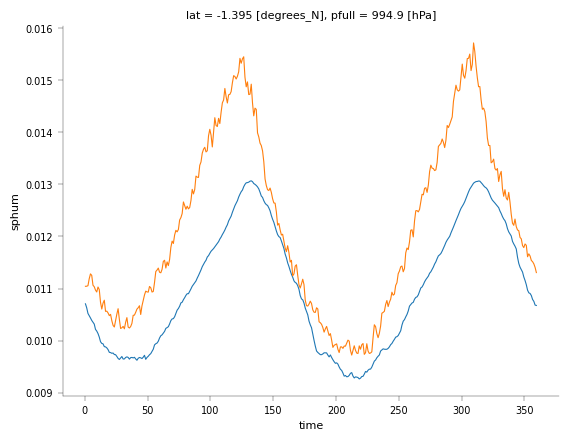

In [403]:
ds_use['conv'].sphum[:, -1].plot()
ds_use['no_conv'].sphum[:, -1].plot()

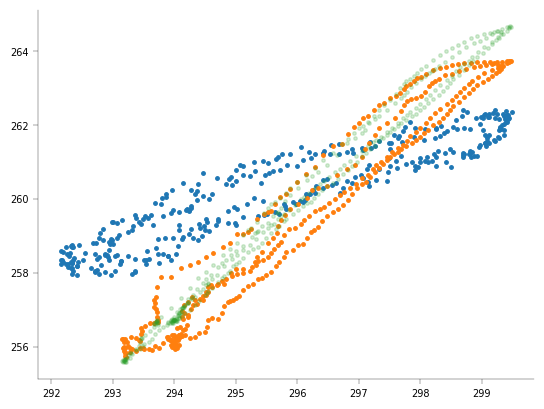

In [404]:
plt.scatter(ds_use['no_conv'].temp[:, -1], ds_use['no_conv'].temp[:, 1])
plt.scatter(ds_use['conv'].temp[:, -1], ds_use['conv'].temp[:, 1])
plt.scatter(ds_use['conv'].temp[:, -1], gif_info['temp_adiabat'][:, 1], alpha=0.2)
# plt.ylim(245, 275)

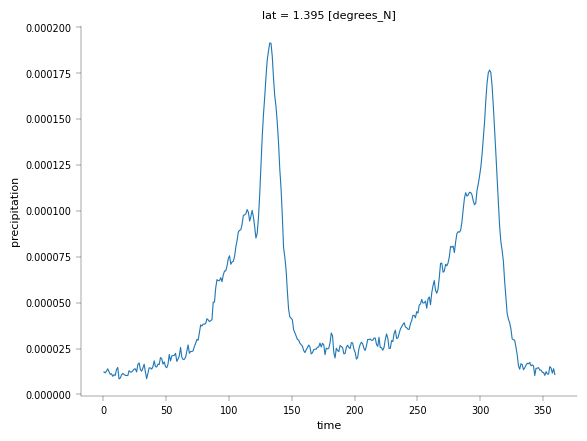

In [445]:
ds_use['conv'].precipitation.plot()

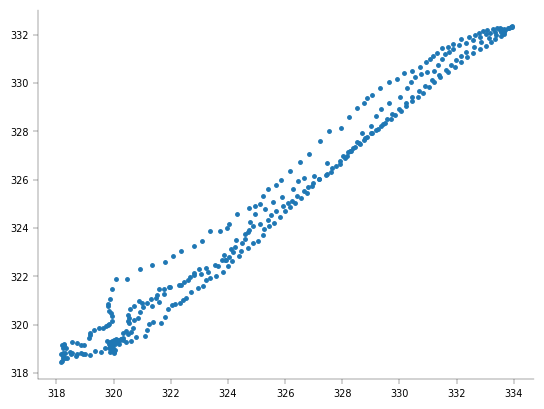

In [444]:
plt.scatter(mse_surf_timeseries['conv'], mse_ft_timeseries['conv'])

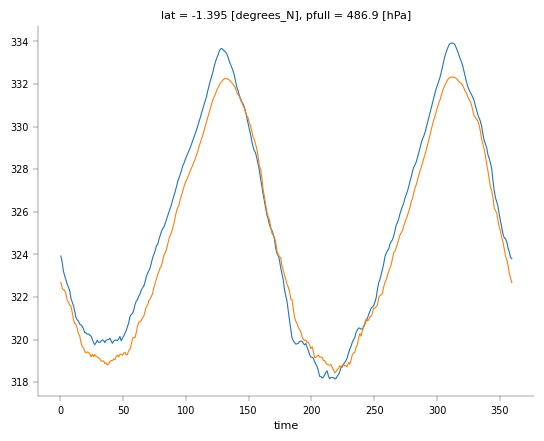

In [443]:
mse_surf_timeseries['conv'].plot()
mse_ft_timeseries['conv'].plot()

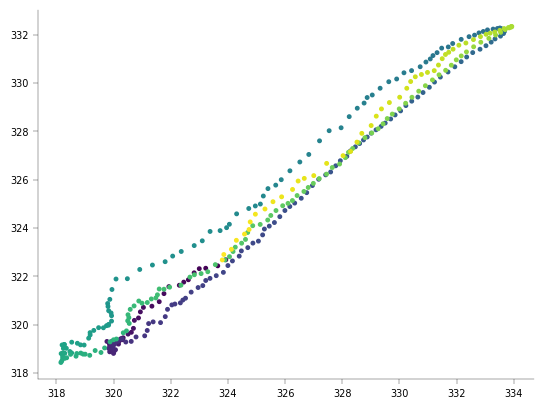

In [422]:
mse_surf_timeseries = {key: moist_static_energy(ds_use[key].temp[:, -1], ds_use[key].sphum[:, -1], ds_use[key].height[:, -1]) for key in ds_use}
mse_ft_timeseries = {key: moist_static_energy(ds_use[key].temp[:, 1], sphum_sat(ds_use[key].temp[:, 1], ds_use[key].pfull[1]*100), 
                                              ds_use[key].height[:, 1]) for key in ds_use}
plt.scatter(mse_surf_timeseries['conv'], mse_ft_timeseries['conv'], c=ds['conv'][0].time)#, s=(ds_use['conv'].precipitation*30000)**4)
# plt.scatter(mse_surf_timeseries['no_conv'], mse_ft_timeseries['no_conv'], s=(ds_use['no_conv'].precipitation*30000)**4)
# plt.xlim(360, 370)
# plt.ylim(360, 370)

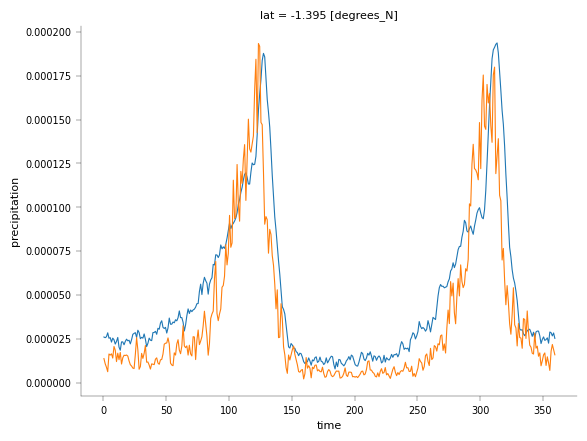

In [407]:
ds_use['conv'].precipitation.plot()
ds_use['no_conv'].precipitation.plot()

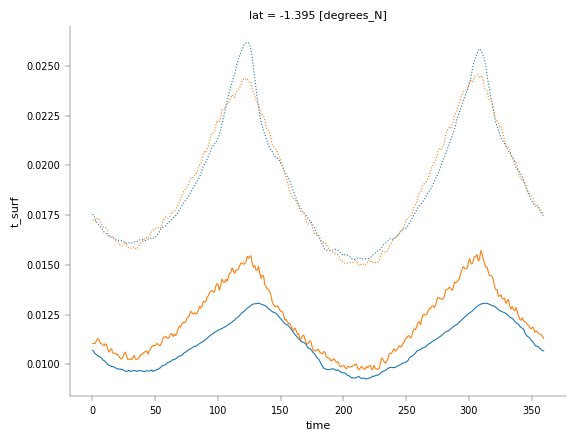

In [408]:
ds_use['conv'].sphum[:, -1].plot(color=default_colors[0])
sphum_sat(ds_use['conv'].t_surf, p_surface).plot(color=default_colors[0], linestyle=':')
ds_use['no_conv'].sphum[:, -1].plot(color=default_colors[1])
sphum_sat(ds_use['no_conv'].t_surf, p_surface).plot(color=default_colors[1], linestyle=':')

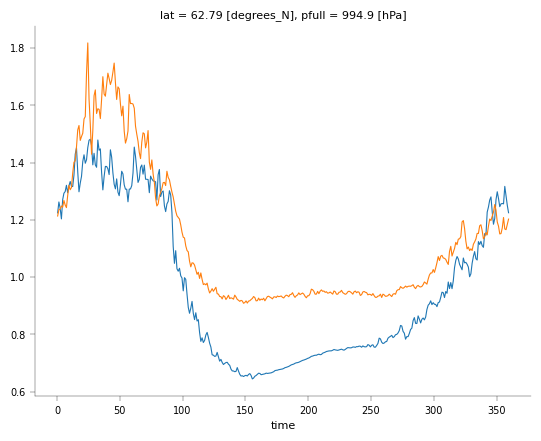

In [541]:
(ds_use['conv'].sphum[:, -1]/sphum_sat(ds_use['conv'].temp[:, -1], p_surface)).plot()
(ds_use['no_conv'].sphum[:, -1]/sphum_sat(ds_use['no_conv'].temp[:, -1], p_surface)).plot()
# ds_use['no_conv'].sphum[:, -1].plot(color=default_colors[1])
# sphum_sat(ds_use['no_conv'].t_surf, p_surface).plot(color=default_colors[1], linestyle=':')

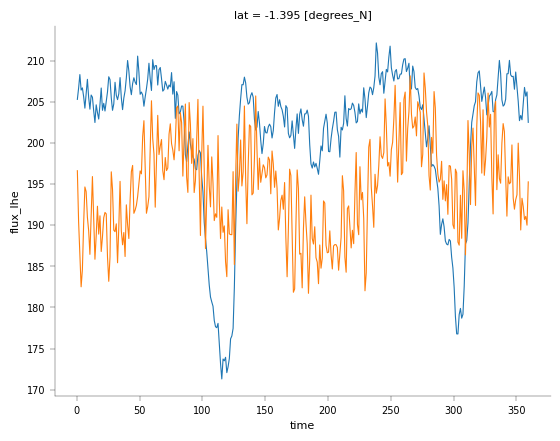

In [410]:
ds_use['conv'].flux_lhe.plot()
ds_use['no_conv'].flux_lhe.plot()

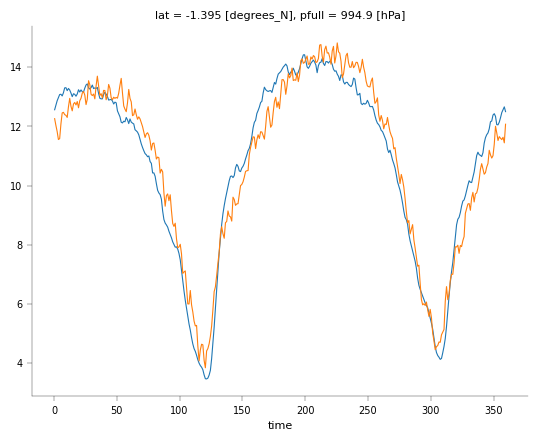

In [411]:
np.sqrt(ds_use['conv'].ucomp[:, -1]**2+ds_use['conv'].vcomp[:, -1]**2).plot()
np.sqrt(ds_use['no_conv'].ucomp[:, -1]**2+ds_use['no_conv'].vcomp[:, -1]**2).plot()

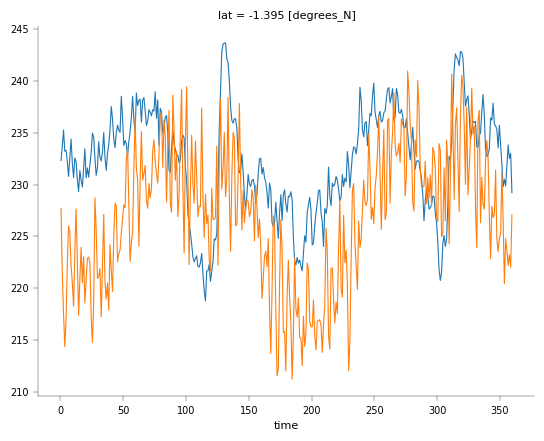

In [412]:
(ds_use['conv'].lwup_sfc - ds_use['conv'].lwdn_sfc + ds_use['conv'].flux_lhe).plot()
(ds_use['no_conv'].lwup_sfc - ds_use['no_conv'].lwdn_sfc + ds_use['no_conv'].flux_lhe).plot()